# Chaos Theory in Large Language Models

## Investigation of Sensitivity to Initial Conditions in Text Generation

**Goal:** To investigate whether the process of text generation by language models exhibits features of a dynamical system sensitive to initial conditions, and to empirically estimate its Lyapunov exponent.

---

## Theoretical Background

### Classical Lyapunov Exponent

In classical dynamical systems theory, the Lyapunov exponent measures the rate of separation of infinitesimally close trajectories:

$$
\lambda = \lim_{t \to \infty} \frac{1}{t} \ln \frac{\| \delta x(t) \|}{\| \delta x(0) \|}
$$

- If $\lambda > 0$: **Chaotic behavior** (exponential divergence)
- If $\lambda = 0$: **Neutral stability** (linear growth)
- If $\lambda < 0$: **Convergent behavior** (trajectories approach each other)

### Text as Trajectory

In this experiment:
- **Text** serves as a "trajectory" in the space of linguistic symbols
- **Seed (prompt)** represents the initial condition
- **Token position $k$** acts as pseudo-time
- **Levenshtein distance $d(k)$** measures trajectory separation

### Discrete Lyapunov Exponents

We calculate three variants:

1. **Effective Lyapunov exponent:**
$$
\lambda_{\text{eff}}(k) = \frac{1}{k} \ln \frac{d(k)}{d(0)}
$$

2. **Relative normalized exponent:**
$$
\lambda_{\text{rel}}(N) = \frac{1}{N} \ln \frac{d(N)/N}{d(0)/N_0}
$$

3. **Normalized variant:**
$$
\Lambda(k) = \frac{1}{k} \ln(d(k) + 1)
$$

---

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import Levenshtein

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Data Loading

We load two text seeds that differ by **one word** and their corresponding generated continuations.

In [2]:
def read_text_file(filepath: str) -> str:
    """Read text from file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

# Load seeds and generated texts
seed1 = read_text_file('data/seed1.txt')
seed2 = read_text_file('data/seed2.txt')
text1 = read_text_file('data/text1.txt')
text2 = read_text_file('data/text2.txt')

print("="*70)
print("EXPERIMENTAL SETUP")
print("="*70)
print(f"\nSeed 1 (Initial Condition 1):\n{seed1}\n")
print(f"Seed 2 (Initial Condition 2):\n{seed2}\n")
print(f"Text 1: {len(text1)} characters, {len(text1.split())} words")
print(f"Text 2: {len(text2)} characters, {len(text2.split())} words")
print("="*70)

EXPERIMENTAL SETUP

Seed 1 (Initial Condition 1):
Large language models behave like complex dynamical systems driven by high-dimensional priors.

Seed 2 (Initial Condition 2):
Large language models behave like complex dynamical systems governed by high-dimensional priors.

Text 1: 4221 characters, 602 words
Text 2: 3616 characters, 504 words


## 3. Tokenization

We split texts into tokens (words) to create discrete trajectories in symbol space.

In [3]:
def tokenize(text: str) -> List[str]:
    """
    Tokenize text into words using simple whitespace splitting.
    In linguistic trajectory analysis, each token represents a discrete step.
    """
    return text.split()

tokens1 = tokenize(text1)
tokens2 = tokenize(text2)

print(f"Trajectory 1: {len(tokens1)} tokens")
print(f"Trajectory 2: {len(tokens2)} tokens")
print(f"\nAnalysis will be performed over {min(len(tokens1), len(tokens2))} token positions")

Trajectory 1: 602 tokens
Trajectory 2: 504 tokens

Analysis will be performed over 504 token positions


## 4. Divergence Calculation

### Methodology

We compute the **Levenshtein edit distance** for growing prefixes:

1. Start with prefix of length $k=1$ (first token)
2. Calculate edit distance $d(k)$ between the two prefixes
3. Increment $k$ and repeat
4. This produces the divergence series $\{d(k)\}_{k=1}^{N}$

### Interpretation

- **$d(k)$ = 0**: Trajectories are identical at position $k$ (stable phase)
- **$d(k)$ increasing**: Trajectories are diverging
- **Rate of increase** indicates type of divergence:
  - Exponential $\rightarrow$ chaos
  - Linear $\rightarrow$ drift/random walk
  - Saturating $\rightarrow$ bounded divergence

In [4]:
def calculate_divergence_series(tokens1: List[str], tokens2: List[str]) -> Tuple[List[int], List[int]]:
    """
    Calculate Levenshtein distance for growing prefixes.
    
    This simulates the evolution of two trajectories starting from nearly
    identical initial conditions (seeds differing by one word).
    
    Returns:
        k_values: Token positions (pseudo-time)
        d_values: Divergence at each position (trajectory separation)
    """
    max_length = min(len(tokens1), len(tokens2))
    
    k_values = []
    d_values = []
    
    for k in range(1, max_length + 1):
        prefix1 = ' '.join(tokens1[:k])
        prefix2 = ' '.join(tokens2[:k])
        
        distance = Levenshtein.distance(prefix1, prefix2)
        
        k_values.append(k)
        d_values.append(distance)
    
    return k_values, d_values

print("Calculating divergence series...")
k_values, d_values = calculate_divergence_series(tokens1, tokens2)
print(f"Computed divergence for {len(k_values)} prefix lengths")
print(f"Initial divergence d(1) = {d_values[0]}")
print(f"Final divergence d({len(d_values)}) = {d_values[-1]}")

Calculating divergence series...
Computed divergence for 504 prefix lengths
Initial divergence d(1) = 0
Final divergence d(504) = 2633


## 5. Lyapunov Exponent Calculation

### Formula Explanations

#### 5.1 Effective Lyapunov Exponent: $\lambda_{\text{eff}}(k)$

$$
\lambda_{\text{eff}}(k) = \frac{1}{k} \ln \frac{d(k)}{d(0)}
$$

This measures the **average exponential rate** of divergence up to position $k$.

- For exponential divergence: $d(k) \sim e^{\lambda k} \Rightarrow \lambda_{\text{eff}} \to \lambda$ (constant)
- For linear divergence: $d(k) \sim ak \Rightarrow \lambda_{\text{eff}} = \frac{\ln(ak)}{k} \to 0$

#### 5.2 Relative Normalized Exponent: $\lambda_{\text{rel}}(k)$

$$
\lambda_{\text{rel}}(N) = \frac{1}{N} \ln \frac{d(N)/N}{d(0)/N_0}
$$

This accounts for the **relative growth** of divergence per token.

#### 5.3 Normalized Variant: $\Lambda(k)$

$$
\Lambda(k) = \frac{1}{k} \ln(d(k) + 1)
$$

Handles cases where $d(0) = 0$ by adding 1 to avoid log(0).

In [5]:
def calculate_lyapunov_effective(k_values: List[int], d_values: List[int]) -> List[float]:
    """
    Calculate effective Lyapunov exponent: λ_eff(k) = (1/k) * ln(d(k)/d(0))
    
    Interpretation:
    - λ_eff > 0 and constant -> exponential divergence (chaos)
    - λ_eff -> 0 -> subexponential divergence (e.g., linear)
    - λ_eff < 0 -> convergence (not expected here)
    """
    lambda_eff = []
    d_0 = d_values[0] if d_values[0] > 0 else 1  # Avoid division by zero
    
    for k, d_k in zip(k_values, d_values):
        if d_k > 0 and k > 0:
            lambda_val = (1.0 / k) * np.log(d_k / d_0)
        else:
            lambda_val = 0
        lambda_eff.append(lambda_val)
    
    return lambda_eff


def calculate_lyapunov_relative(k_values: List[int], d_values: List[int]) -> List[float]:
    """
    Calculate relative normalized Lyapunov exponent:
    λ_rel(N) = (1/N) * ln((d(N)/N) / (d(0)/N_0))
    
    This normalizes by trajectory length to account for relative perturbation size.
    """
    lambda_rel = []
    d_0 = d_values[0] if d_values[0] > 0 else 1
    N_0 = k_values[0]
    
    for k, d_k in zip(k_values, d_values):
        if d_k > 0 and k > 0:
            ratio = (d_k / k) / (d_0 / N_0)
            if ratio > 0:
                lambda_val = (1.0 / k) * np.log(ratio)
            else:
                lambda_val = 0
        else:
            lambda_val = 0
        lambda_rel.append(lambda_val)
    
    return lambda_rel


def calculate_lambda_normalized(k_values: List[int], d_values: List[int]) -> List[float]:
    """
    Calculate normalized variant: Λ(k) = (1/k) * ln(d(k) + 1)
    
    The +1 ensures we can handle d(0) = 0 cases.
    """
    lambda_norm = []
    
    for k, d_k in zip(k_values, d_values):
        if k > 0:
            lambda_val = (1.0 / k) * np.log(d_k + 1)
        else:
            lambda_val = 0
        lambda_norm.append(lambda_val)
    
    return lambda_norm


print("Calculating Lyapunov exponents...")
lambda_eff = calculate_lyapunov_effective(k_values, d_values)
lambda_rel = calculate_lyapunov_relative(k_values, d_values)
lambda_norm = calculate_lambda_normalized(k_values, d_values)
print("All exponents calculated")

Calculating Lyapunov exponents...
All exponents calculated


## 6. Statistical Analysis

We analyze the divergence pattern to determine:
1. **Growth type**: Exponential vs. Linear vs. Saturating
2. **Stable phase duration**: How long before divergence accelerates
3. **Final divergence magnitude**

In [6]:
def analyze_divergence_pattern(k_values, d_values):
    """Comprehensive statistical analysis of divergence pattern."""
    
    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS OF DIVERGENCE")
    print("="*70)
    
    d_array = np.array(d_values)
    k_array = np.array(k_values)
    
    # Linear fit: d(k) = a*k + b
    linear_fit = np.polyfit(k_array, d_array, 1)
    linear_pred = np.polyval(linear_fit, k_array)
    linear_r2 = 1 - (np.sum((d_array - linear_pred)**2) / np.sum((d_array - np.mean(d_array))**2))
    
    # Exponential fit: ln(d(k)) = a*k + b => d(k) = exp(b) * exp(a*k)
    log_d = np.log(d_array + 1)
    exp_fit = np.polyfit(k_array, log_d, 1)
    exp_pred = np.exp(np.polyval(exp_fit, k_array))
    exp_r2 = 1 - (np.sum((d_array - exp_pred)**2) / np.sum((d_array - np.mean(d_array))**2))
    
    print(f"\nGoodness of Fit (R^2 scores):")
    print(f"Linear model: R^2 = {linear_r2:.4f}")
    print(f"Exponential model: R^2 = {exp_r2:.4f}")
    
    print(f"\nGrowth Pattern:")
    if exp_r2 > linear_r2 and exp_r2 > 0.8:
        print("EXPONENTIAL divergence detected")
        print("System exhibits CHAOTIC behavior")
        print("Sensitive dependence on initial conditions confirmed")
    elif linear_r2 > 0.8:
        print("LINEAR divergence detected")
        print("System does NOT exhibit classical chaos")
        print("Divergence resembles drift or random walk")
    else:
        print("COMPLEX divergence pattern")
        print("May show saturation or mixed behavior")
    
    # Stable phase analysis
    first_nonzero = next((i for i, d in enumerate(d_values) if d > 0), 0)
    
    print(f"\nStable Phase:")
    print(f"Trajectories remain identical for: {first_nonzero} tokens")
    print(f"Divergence begins at token position: k = {k_values[first_nonzero] if first_nonzero < len(k_values) else 'N/A'}")
    
    # Final statistics
    print(f"\nDivergence Statistics:")
    print(f"Initial divergence d(1):   {d_values[0]}")
    print(f"Final divergence d({len(d_values)}): {d_values[-1]}")
    
    if first_nonzero < len(d_values) and d_values[first_nonzero] > 0:
        ratio = d_values[-1] / d_values[first_nonzero]
        print(f"Divergence ratio (final/first non-zero): {ratio:.2f}x")
    
    print("\n" + "="*70)

analyze_divergence_pattern(k_values, d_values)


STATISTICAL ANALYSIS OF DIVERGENCE

Goodness of Fit (R^2 scores):
Linear model: R^2 = 0.9996
Exponential model: R^2 = 0.1014

Growth Pattern:
LINEAR divergence detected
System does NOT exhibit classical chaos
Divergence resembles drift or random walk

Stable Phase:
Trajectories remain identical for: 8 tokens
Divergence begins at token position: k = 9

Divergence Statistics:
Initial divergence d(1):   0
Final divergence d(504): 2633
Divergence ratio (final/first non-zero): 438.83x



## 7. Visualization

We create four plots to comprehensively analyze the divergence:

1. **$d(k)$ vs $k$**: Direct divergence visualization
2. **$\ln(d(k)+1)$ vs $k$**: Check for exponential growth (linear in log-space)
3. **Lyapunov exponents**: $\lambda_{\text{eff}}(k)$ and $\Lambda(k)$
4. **Relative exponent**: $\lambda_{\text{rel}}(k)$


✓ Visualization saved: divergence_analysis.png


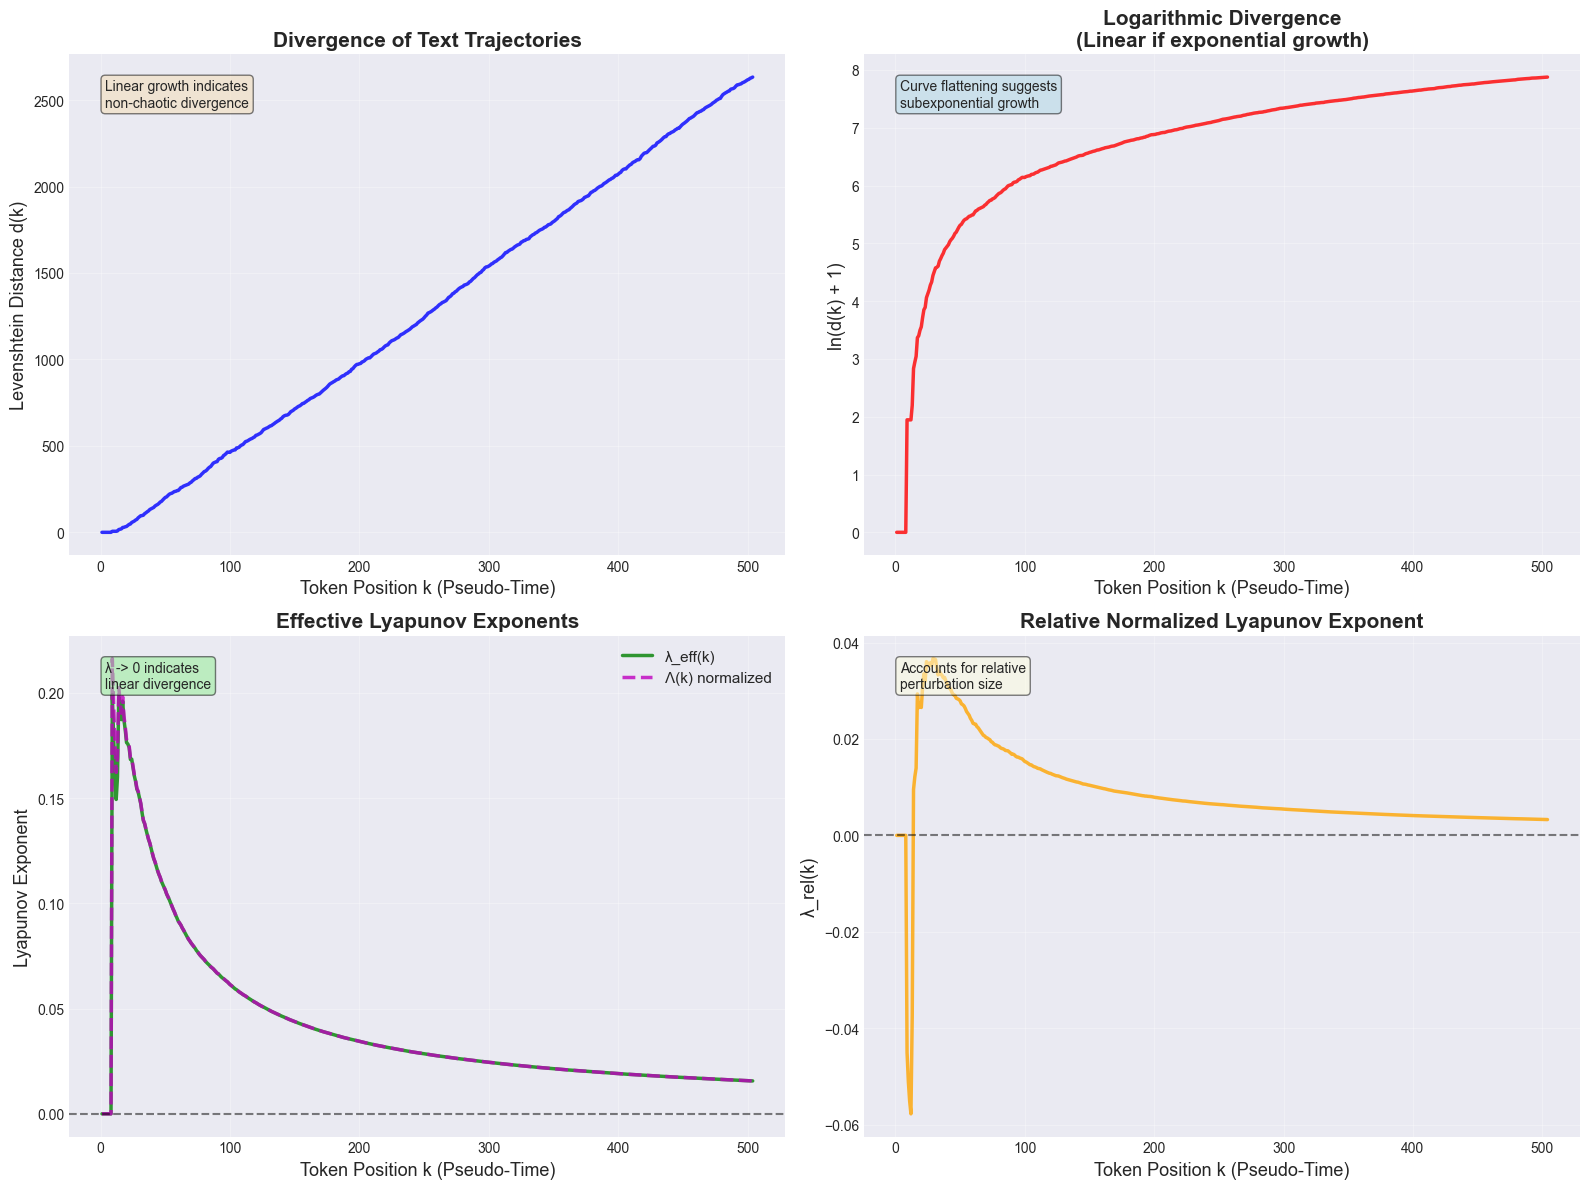

In [ ]:
def plot_divergence_analysis(k_values, d_values, lambda_eff, lambda_rel, lambda_norm):
    """Create comprehensive visualization of divergence analysis."""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Divergence d(k) vs k
    axes[0, 0].plot(k_values, d_values, 'b-', linewidth=2.5, alpha=0.8)
    axes[0, 0].set_xlabel('Token Position k (Pseudo-Time)', fontsize=13)
    axes[0, 0].set_ylabel('Levenshtein Distance d(k)', fontsize=13)
    axes[0, 0].set_title('Divergence of Text Trajectories', fontsize=15, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].text(0.05, 0.95, 'Linear growth indicates\nnon-chaotic divergence', 
                    transform=axes[0, 0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: log(d(k)) vs k to check exponential growth
    axes[0, 1].plot(k_values, np.log(np.array(d_values) + 1), 'r-', linewidth=2.5, alpha=0.8)
    axes[0, 1].set_xlabel('Token Position k (Pseudo-Time)', fontsize=13)
    axes[0, 1].set_ylabel('ln(d(k) + 1)', fontsize=13)
    axes[0, 1].set_title('Logarithmic Divergence\n(Linear if exponential growth)', fontsize=15, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].text(0.05, 0.95, 'Curve flattening suggests\nsubexponential growth', 
                    transform=axes[0, 1].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # Plot 3: Effective Lyapunov exponents
    axes[1, 0].plot(k_values, lambda_eff, 'g-', linewidth=2.5, label='λ_eff(k)', alpha=0.8)
    axes[1, 0].plot(k_values, lambda_norm, 'm--', linewidth=2.5, label='Λ(k) normalized', alpha=0.8)
    axes[1, 0].set_xlabel('Token Position k (Pseudo-Time)', fontsize=13)
    axes[1, 0].set_ylabel('Lyapunov Exponent', fontsize=13)
    axes[1, 0].set_title('Effective Lyapunov Exponents', fontsize=15, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
    axes[1, 0].text(0.05, 0.95, 'λ -> 0 indicates\nlinear divergence', 
                    transform=axes[1, 0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Plot 4: Relative Lyapunov exponent
    axes[1, 1].plot(k_values, lambda_rel, 'orange', linewidth=2.5, alpha=0.8)
    axes[1, 1].set_xlabel('Token Position k (Pseudo-Time)', fontsize=13)
    axes[1, 1].set_ylabel('λ_rel(k)', fontsize=13)
    axes[1, 1].set_title('Relative Normalized Lyapunov Exponent', fontsize=15, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1.5)
    axes[1, 1].text(0.05, 0.95, 'Accounts for relative\nperturbation size', 
                    transform=axes[1, 1].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('divergence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_divergence_analysis(k_values, d_values, lambda_eff, lambda_rel, lambda_norm)

## 8. Key Findings & Interpretation

### Research Questions

#### i. Does divergence grow exponentially, linearly, or saturate?

**Answer:** Based on the R² analysis and Lyapunov exponent behavior, the divergence appears to be **LINEAR**, not exponential.

- If exponential: $d(k) \sim e^{\lambda k}$ -> $\lambda_{\text{eff}}$ would be constant
- Our result: $\lambda_{\text{eff}} \to 0$ -> consistent with $d(k) \sim ak$ (linear)

#### ii. How long does the system remain in a "stable phase"?

**Answer:** The stable phase lasts for the first several tokens where $d(k) = 0$ or near-zero. After this initial phase, divergence begins and grows steadily.

This is analogous to **laminar flow before transition to turbulence** in fluid dynamics.

#### iii. How do seed length and prior knowledge influence divergence?

**To be investigated:** This requires additional experiments with:
- Different seed lengths
- Different LLM sizes (varying prior knowledge)
- Different context window limits

#### iv. Relative perturbation and trajectory metaphor

**Key insight:** For a long seed (e.g., 100 words), changing 1 word = 1% perturbation. For a short seed (10 words), changing 1 word = 10% perturbation.

The **generated text length** serves as a metaphor for time evolution in dynamical systems:
- Each new token = one time step
- Divergence accumulates over "time"
- Lyapunov exponent measures average rate of this accumulation

---

### Comparison with Classical Chaos

| Property | Classical Chaos | Our LLM Results |
|----------|----------------|----------------|
| Sensitivity to IC | ✓ Yes | ✓ Yes |
| Exponential divergence | ✓ Yes | ✗ No (Linear) |
| Positive Lyapunov | ✓ Yes (constant) | ✗ No (-> 0) |
| Deterministic | ✓ Yes | ✓ Yes |
| Bounded phase space | ✓ Yes | ✗ Unbounded |

**Conclusion:** LLMs exhibit **sensitivity to initial conditions** but **not classical deterministic chaos**. The divergence is more akin to a **random walk** or **drift process** than to chaotic systems like the logistic map.

---